In [102]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud
import re
import string

In [52]:
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Triary Labels

In [3]:
df = pd.read_csv("airlinetweets.csv", encoding="ISO-8859-1")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [37]:
labels = df["airline_sentiment"]
inputs = df["text"]

In [38]:
inputs

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [39]:
def cleaner(impure_data):
    temp_list = []
    for item in impure_data:
        #finding words which start with @
        item = re.sub('@\S+', '', item)
        #finding words which start with http
        item = re.sub('http\S+\s*', '', item)
        temp_list.append(item)
    return temp_list

In [40]:
inputs = cleaner(inputs)
lemma = WordNetLemmatizer()
inputs

[' What  said.',
 " plus you've added commercials to the experience... tacky.",
 " I didn't today... Must mean I need to take another trip!",
 ' it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 " and it's a really big bad thing about it",
 " seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA",
 ' yes, nearly every time I fly VX this â\x80\x9cear wormâ\x80\x9d wonâ\x80\x99t go away :)',
 ' Really missed a prime opportunity for Men Without Hats parody, there. ',
 " Well, I didn'tâ\x80¦but NOW I DO! :-D",
 " it was amazing, and arrived an hour early. You're too good to me.",
 ' did you know that suicide is the second leading cause of death among teens 10-24',
 ' I &lt;3 pretty graphics. so much better than minimal iconography. :D',
 " This is such a great deal! Already thinking about my 2nd trip to  &amp; I haven't even gone on my 1st trip yet! ;p",
 "

In [107]:
def preprocess(impure_data):
    temp_list = []
    for input_ in impure_data:
        input_ = input_.strip().lower()
        if input_:
            input_ = input_.translate(str.maketrans('', '', string.punctuation))
            input_ = word_tokenize(input_)
            def get_wordnet_pos(treebank_tag):
                if treebank_tag.startswith("J"):
                    return wordnet.ADJ
                elif treebank_tag.startswith("V"):
                    return wordnet.VERB
                elif treebank_tag.startswith("R"):
                    return wordnet.ADV
                else:
                    return wordnet.NOUN
            words_and_tags = nltk.pos_tag(input_)
            input_ = [lemma.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags]
            input_ = [t for t in input_ if len(t) > 2]
            input_ = [t for t in input_ if not any(c.isdigit() for c in t)]
            input_ = " ".join(input_)
            temp_list.append(input_)
    return temp_list

In [108]:
ipts_ = preprocess(inputs)

In [109]:
df["cleaned_texts"] = ipts_
df["cleaned_texts"]

0                                                 what say
1         plus youve added commercial the experience tacky
2             didnt today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                           and really big bad thing about
                               ...                        
14635               thank you get different flight chicago
14636    leave over minute late flight warning communic...
14637                        please bring american airline
14638    you have money you change flight and dont answ...
14639    have ppl need know how many seat the next flig...
Name: cleaned_texts, Length: 14640, dtype: object

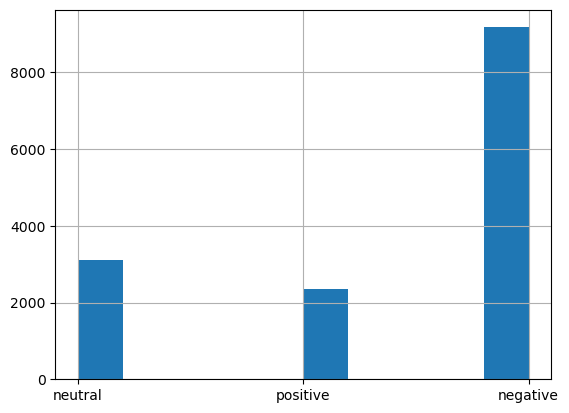

In [117]:
df["airline_sentiment"].hist();

In [116]:
df["b_labels"] = df["airline_sentiment"].map({"neutral": 0, "positive": 1, "negative": 2})

In [118]:
data = df["cleaned_texts"]
labels = df["b_labels"].to_numpy()
train_x, test_x, Ytrain, Ytest = train_test_split(data, labels, test_size=0.33)

In [119]:
vectorizer = TfidfVectorizer(stop_words="english")
Xtrain = vectorizer.fit_transform(train_x)
Xtest = vectorizer.transform(test_x)

In [120]:
Xtrain

<9808x8173 sparse matrix of type '<class 'numpy.float64'>'
	with 69618 stored elements in Compressed Sparse Row format>

In [137]:
model = LogisticRegression(max_iter=1000)
model.fit(Xtrain, Ytrain)
print(f"train accuracy: {model.score(Xtrain, Ytrain)}")
print(f"test accuracy: {model.score(Xtest, Ytest)}")

train accuracy: 0.8608278955954323
test accuracy: 0.7690397350993378


In [138]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
print(f"train f1 score: {f1_score(Ytrain, Ptrain, average='micro')}")
print(f"test f1 score: {f1_score(Ytest, Ptest, average='micro')}")

train f1 score: 0.8608278955954322
test f1 score: 0.7690397350993378


In [139]:
prob_train = model.predict_proba(Xtrain)
prob_test = model.predict_proba(Xtest)
print(f"train roc-auc score {roc_auc_score(Ytrain, prob_train, multi_class='ovo')}")
print(f"test roc-auc score {roc_auc_score(Ytest, prob_test, multi_class='ovo')}")

train roc-auc score 0.9495529212109918
test roc-auc score 0.8719599160585568


In [141]:
cm = confusion_matrix(Ytrain, Ptrain)
cm

array([[1308,   84,  680],
       [  96, 1149,  360],
       [  88,   57, 5986]], dtype=int64)

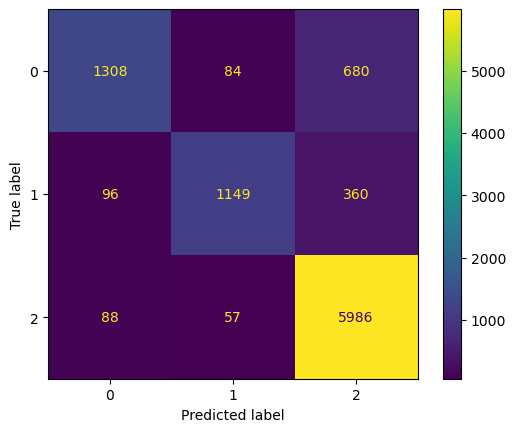

In [142]:
ConfusionMatrixDisplay.from_predictions(Ytrain, Ptrain)

In [143]:
def visualize(label):
    words = ""
    for msg in df[df["airline_sentiment"] == label]["cleaned_texts"]:
        words += msg + " "
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

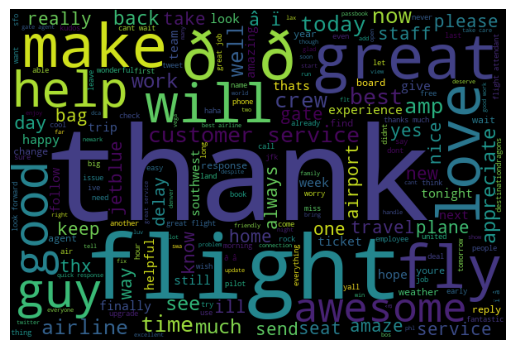

In [145]:
visualize("positive")

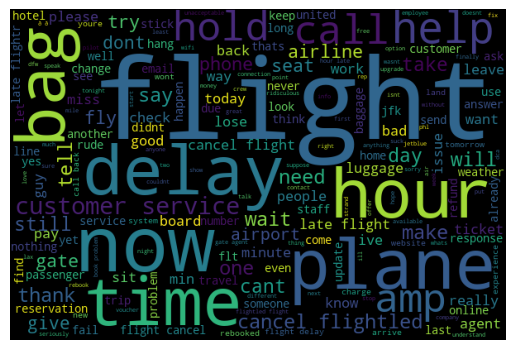

In [147]:
visualize("negative")

In [148]:
X = vectorizer.transform(df["cleaned_texts"])
df["predictions"] = model.predict(X)

In [152]:
sneaky_positive = df[(df["predictions"] == 1 & ((df["b_labels"] == 0) | (df["b_labels"] == 2)))]["cleaned_texts"]
for msg in sneaky_positive:
    print(msg)

view downtown los angeles the hollywood sign and beyond that rain the mountain
julie andrews all the way though very impressive
wish you fly out atlanta soon
you know need spotify stat guiltypleasures
all great but have with carrieunderwood ðð
have getaway deal through may from oneway lot cool city cheapflights farecompare
have getaway deal through may from oneway lot cool city cheapflights farecompare
flight home sunset globe backtowinter back work refreshed
ð youâve meet your match get status another airline upgrade restr
husband and order three drink via screen and they never come awesome
mean probably inappropriate while board but
how about some free drink the flight back for the free promo
nice lofty view silverstatus
new airline
flight book problem last second flight for next week from sfo san any chance you want gift promo code since love you guy
for grandma ellas she would bday greeting from your flight crew she stewardess for eastern airline
omg omgðð nonstop 

In [154]:
sneaky_negative = df[(df["predictions"] == 2 & ((df["b_labels"] == 0) | (df["b_labels"] == 1)))]["cleaned_texts"]
for msg in sneaky_negative:
    print(msg)

you know that suicide the second leading cause death among teen
will you make bosgtlas non stop permanently anytime soon
nice vibe with the moodlight from takeoff touchdown moodlitmonday sciencebehindtheexperience
when can book flight hawaii
view downtown los angeles the hollywood sign and beyond that rain the mountain
plz help win bid upgrade for flight laxgtsea ð·ððºâï¸
flight leave dallas for seattle time feb
dream
after last night tribute soundofmusic think agree
julie andrews all the way though very impressive
will flight leave dallas for february
you know need spotify stat guiltypleasures
carrie
new marketing song let know what you think
julie andrew first but lady gaga wowd last night carrie meh
sorry mary martin have first
flight dal dca try check could not status please
watch some the best student film the country foot
cant bring reservation online use flight book problem code
random whats the distribution elevate avatar bet that kitty have disproportionate share
you

# Binary Labels

In [155]:
data = df[(df["airline_sentiment"] == "positive") | (df["airline_sentiment"] == "negative")]["cleaned_texts"]
labels = df[(df["airline_sentiment"] == "positive") | (df["airline_sentiment"] == "negative")]["b_labels"].to_numpy()
train_x, test_x, Ytrain, Ytest = train_test_split(data, labels, test_size=0.33)

In [172]:
vectorizer = TfidfVectorizer(stop_words="english")
Xtrain = vectorizer.fit_transform(train_x)
Xtest = vectorizer.transform(test_x)

In [158]:
Xtrain

<7732x7107 sparse matrix of type '<class 'numpy.float64'>'
	with 58327 stored elements in Compressed Sparse Row format>

In [159]:
model = LogisticRegression(max_iter=1000)
model.fit(Xtrain, Ytrain)
print(f"train accuracy: {model.score(Xtrain, Ytrain)}")
print(f"test accuracy: {model.score(Xtest, Ytest)}")

train accuracy: 0.913347128815313
test accuracy: 0.8981359936991337


In [161]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
print(f"train f1 score: {f1_score(Ytrain, Ptrain)}")
print(f"test f1 score: {f1_score(Ytest, Ptest)}")

train f1 score: 0.7425057647963106
test f1 score: 0.6978193146417446


In [164]:
prob_train = model.predict_proba(Xtrain)[:, 1]
prob_test = model.predict_proba(Xtest)[:, 1]
print(f"train roc-auc score {roc_auc_score(Ytrain, prob_train)}")
print(f"test roc-auc score {roc_auc_score(Ytest, prob_test)}")

train roc-auc score 0.9768332074968088
test roc-auc score 0.9483476139925184


In [165]:
cm = confusion_matrix(Ytrain, Ptrain)
cm

array([[ 966,  612],
       [  58, 6096]], dtype=int64)

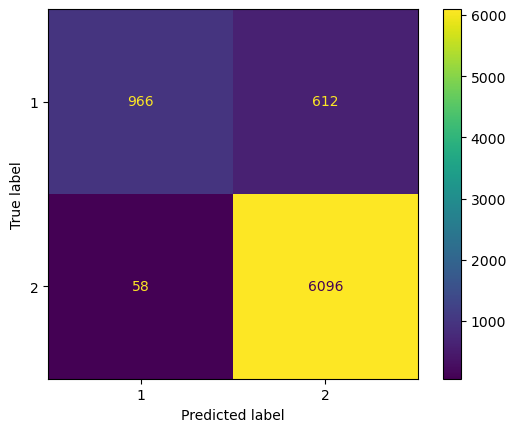

In [166]:
ConfusionMatrixDisplay.from_predictions(Ytrain, Ptrain)

In [167]:
def visualize(label):
    words = ""
    for msg in df[df["airline_sentiment"] == label]["cleaned_texts"]:
        words += msg + " "
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

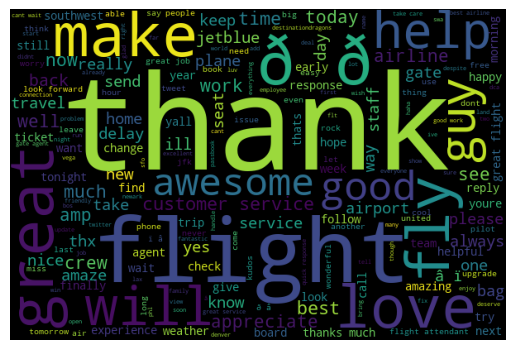

In [168]:
visualize("positive")

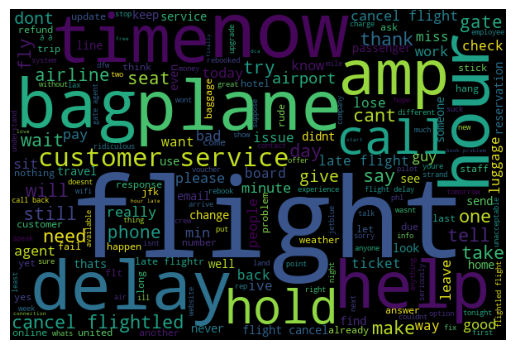

In [169]:
visualize("negative")